In [6]:
import os
import pickle
from functools import partial

import matplotlib.pyplot as plt
import tensorflow as tf

from bayesflow import benchmarks
from bayesflow.amortizers import (
    AmortizedPosterior,
    AmortizedLikelihood,
    AmortizedPosteriorLikelihood,
)
from bayesflow.networks import InvertibleNetwork
from bayesflow.trainers import Trainer
from bayesflow.diagnostics import (
    plot_sbc_ecdf,
    plot_recovery,
    plot_losses,
    plot_posterior_2d,
)

In [7]:
# Comment out, if you want tensorflow warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Benchmark: Simple Likelihood, Complex Posterior (SLCP)

A more challenging version of the original SLCP. This one features 92 distractor variables, unrelated to the original summary statistics.

In [8]:
benchmark_name = 'slcp_distractors'
benchmark = benchmarks.Benchmark(benchmark_name)

INFO:root:Performing 2 pilot runs with the slcp_distractors model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


# Amortizer and Trainer

In [9]:
# Use a small summary network for summarizing the data
summary_net = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16)
])

In [10]:
settings = {
    'spline': {'dropout_prob': 0.3},
    'affine': {'dropout_prob': 0.3, 
               'dense_args': dict(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(5e-4))}
}


amortizer = AmortizedPosteriorLikelihood(
    AmortizedPosterior(
        inference_net=InvertibleNetwork(
            num_params=5, 
            num_coupling_layers=8,
            coupling_design='interleaved',
            coupling_settings=settings
        ), 
        summary_net=summary_net),
    AmortizedLikelihood(
        InvertibleNetwork(
            num_params=100, 
            coupling_design='interleaved',
            coupling_settings=settings
        )
    )
)

In [11]:
config = partial(benchmark.configurator, as_summary_condition=True)
trainer = Trainer(
    amortizer=amortizer,
    generative_model=benchmark.generative_model,
    configurator=config,
    checkpoint_path=f'checkpoints/{benchmark_name}',
    memory=False,
    max_to_keep=1
)

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Training
Uncomment for training. Wall-clock time on GPU: 33min 1s

In [ ]:
# EPOCHS = 60
# SIMULATION_BUDGET = 10000
# BATCH_SIZE = 32
# N_VAL = 300

# train_data = trainer.generative_model(SIMULATION_BUDGET)

In [ ]:
# %%time
# h = trainer.train_offline(train_data, EPOCHS, BATCH_SIZE, validation_sims=N_VAL)

# Validation

## Loss Trajectories

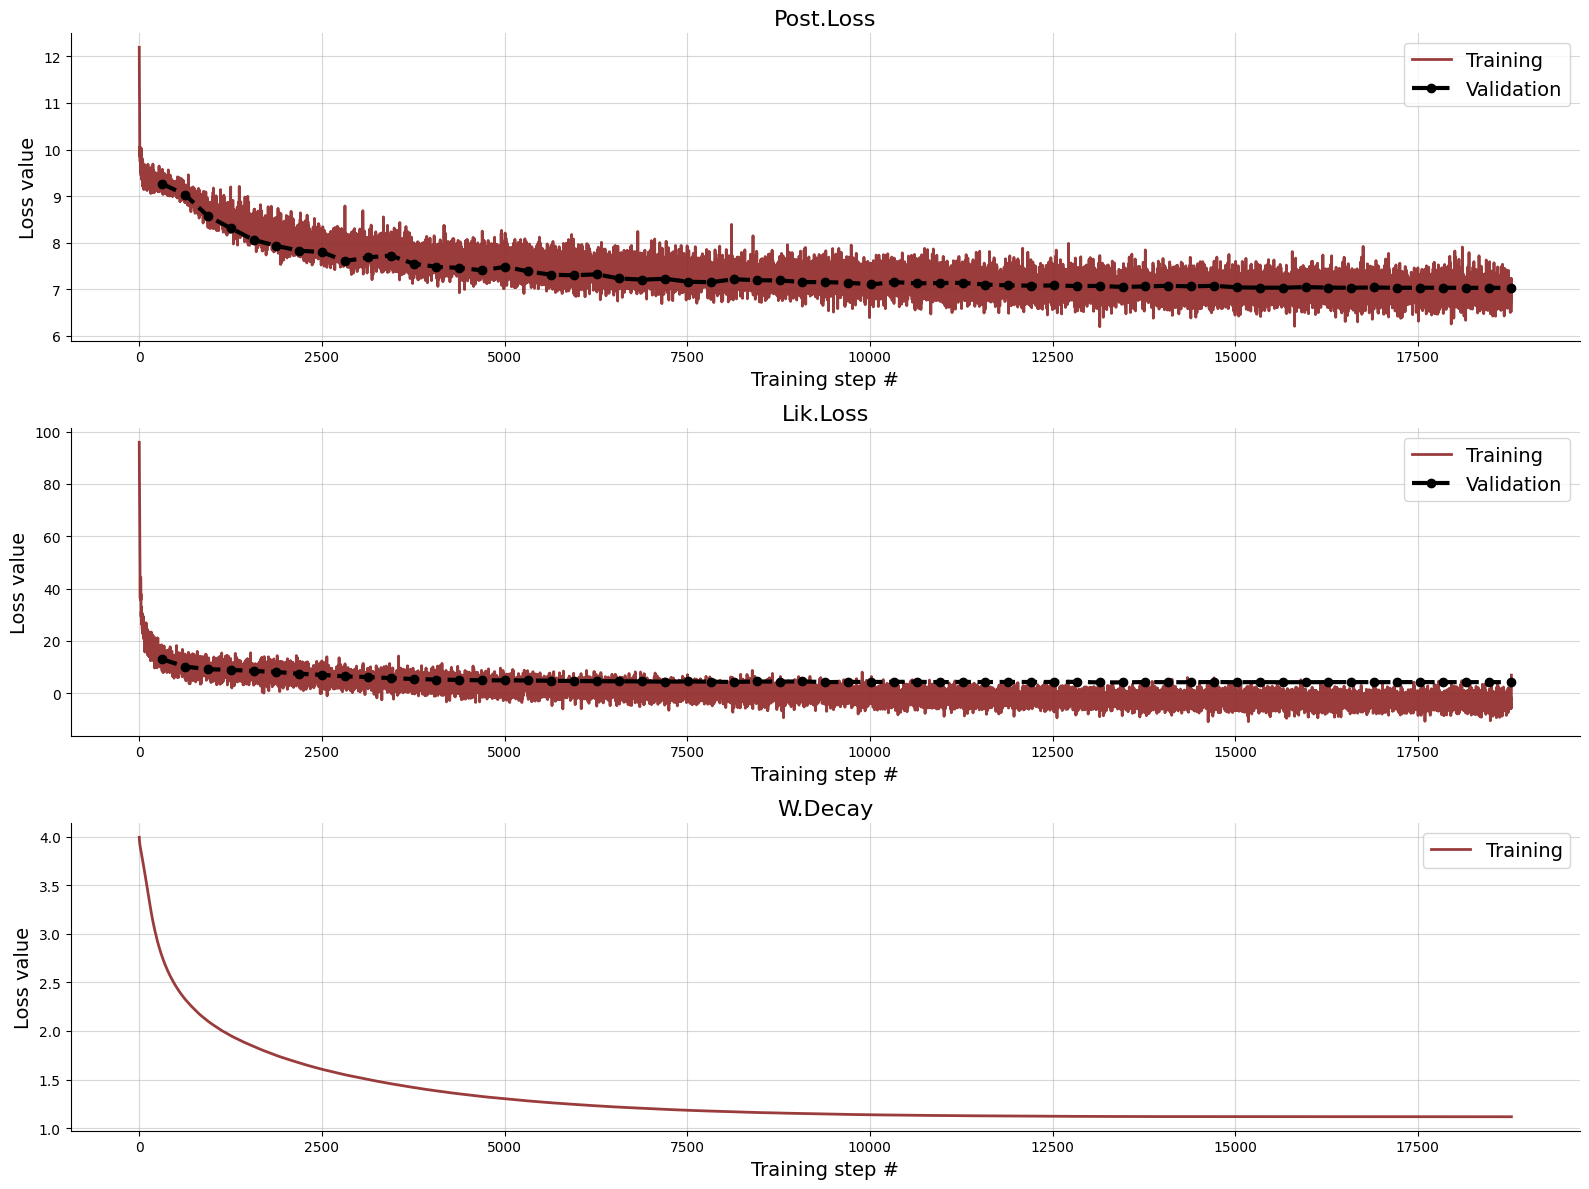

In [14]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])

In [15]:
# Load test data
with open(f'test_data/{benchmark_name}_test.pkl', 'rb') as f:
    test_dict = pickle.load(f)

In [16]:
# Simulate from surrogate simulator
x_sim_s = amortizer.sample_data(test_dict, n_samples=1)
x_sim_s = tf.squeeze(x_sim_s)

# Sample from posteriors given surrogate outputs
post_samples_s = amortizer.sample_parameters({'summary_conditions': x_sim_s}, n_samples=250)

# Sample from posteriors given simulator outputs
post_samples = amortizer.sample_parameters(test_dict, n_samples=250)

# Prior samples
prior_samples = test_dict['posterior_inputs']['parameters']

## Individual ECDF Calibration Plots

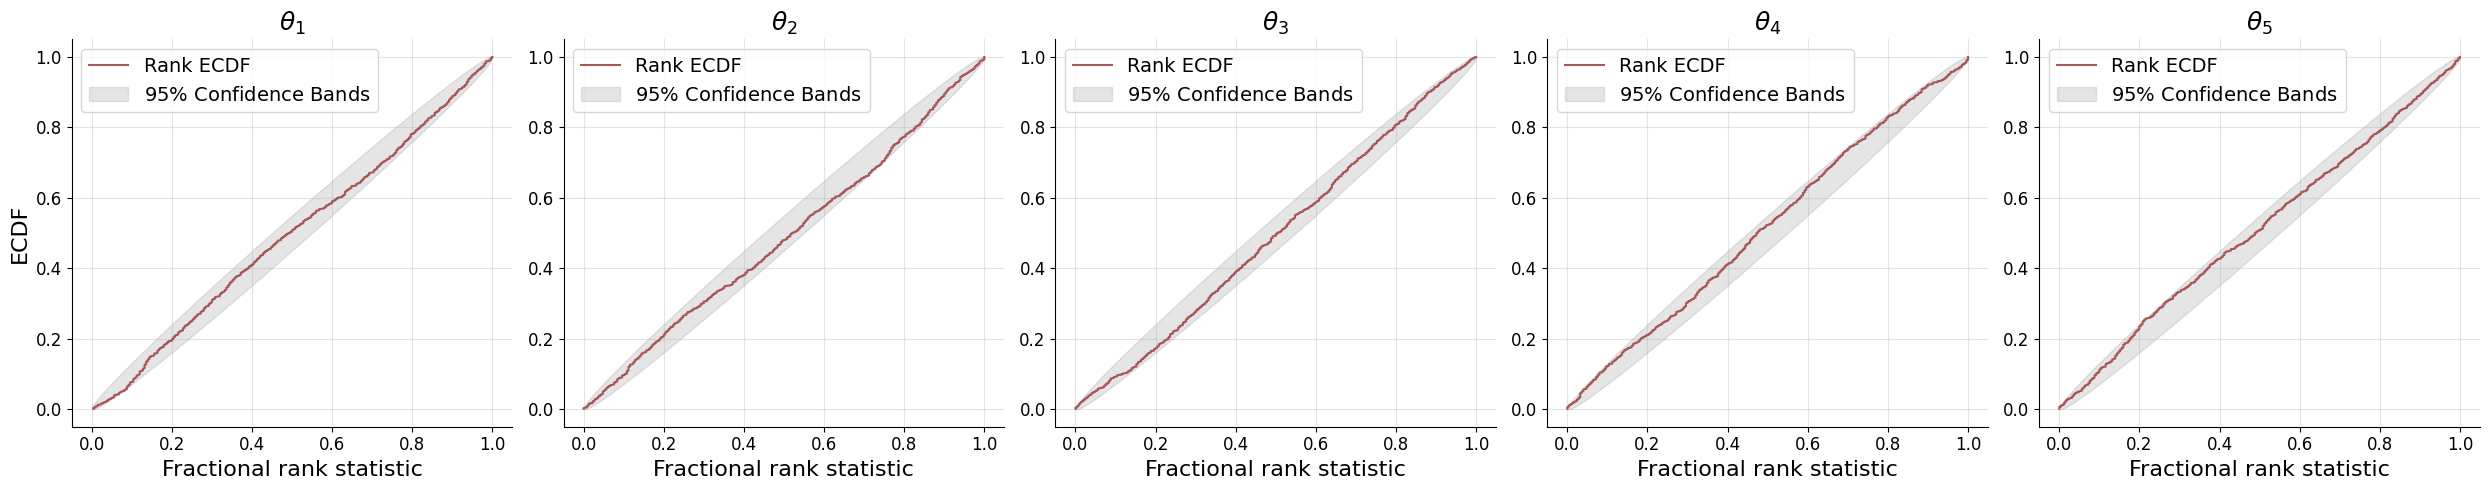

In [17]:
f = plot_sbc_ecdf(post_samples_s, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95))

## Recovery
Observe the hints for bimodality!

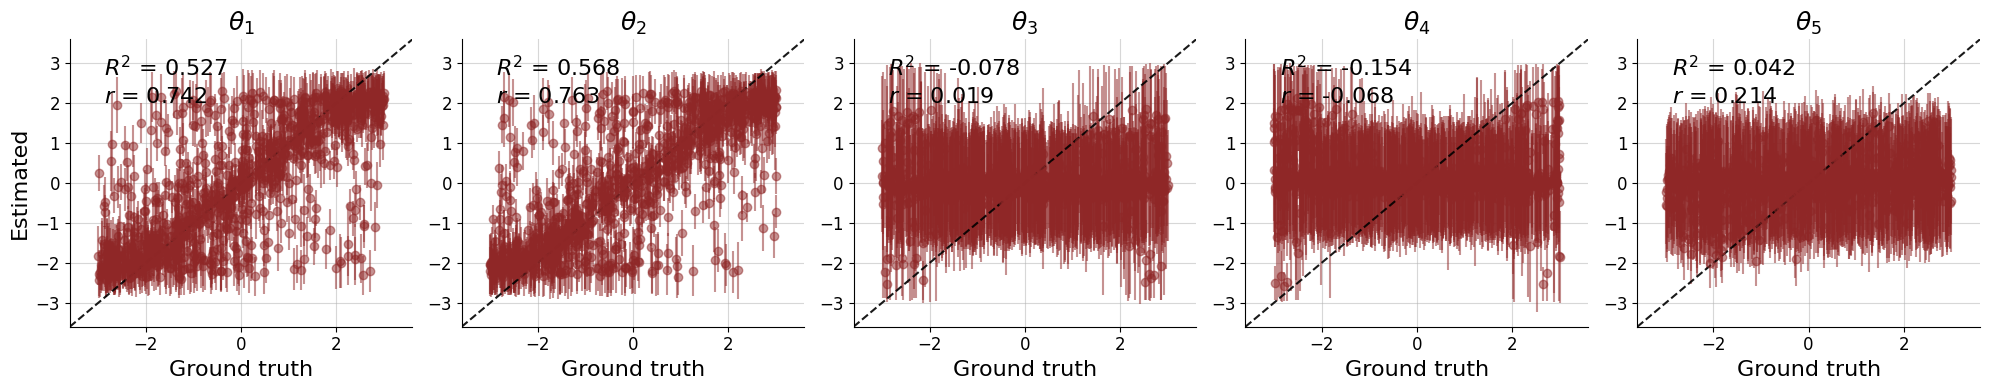

In [18]:
f = plot_recovery(post_samples, prior_samples)

### Example Bivariate Posteriors

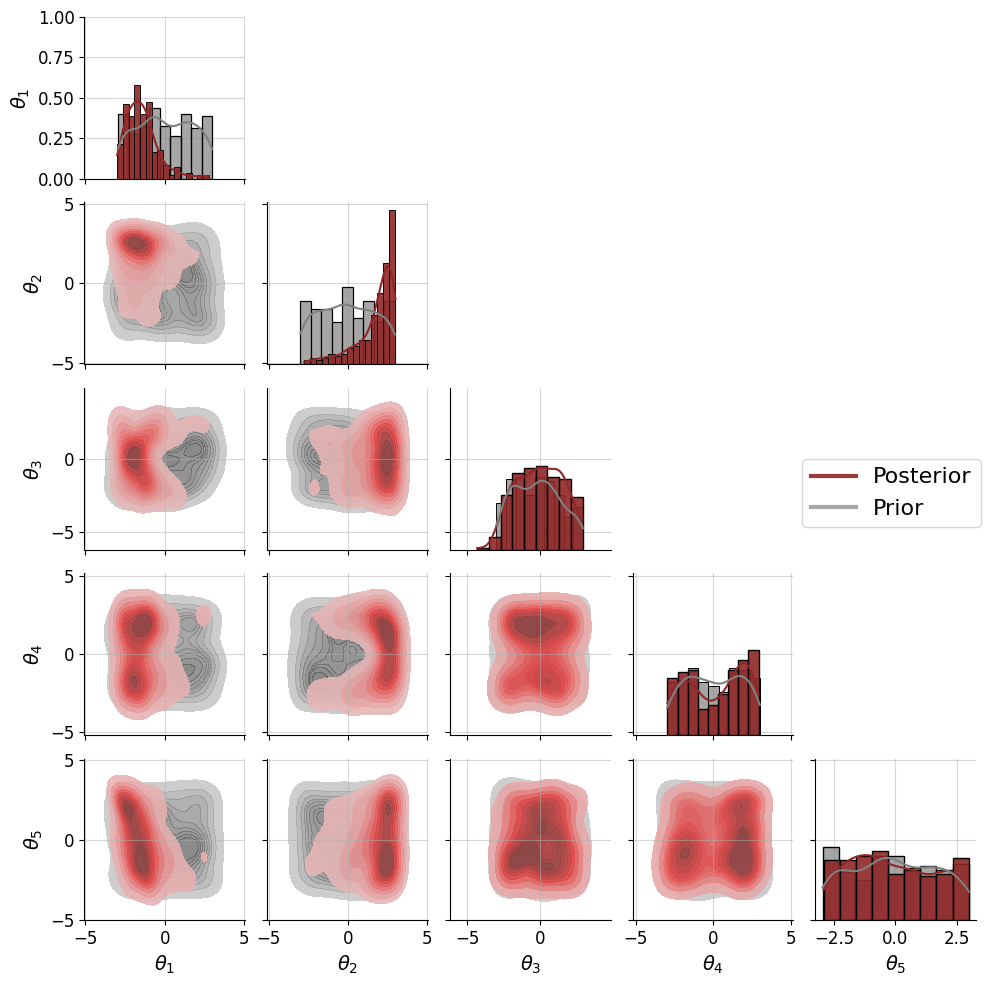

In [19]:
f = plot_posterior_2d(post_samples[0], prior=benchmark.generative_model.prior, height=2)

# Appendix Plots

In [20]:
# load custom tighter plotting function
from custom_plots import plot_sbc_ecdf_appendix

# adjust for better readability
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

### Loss History

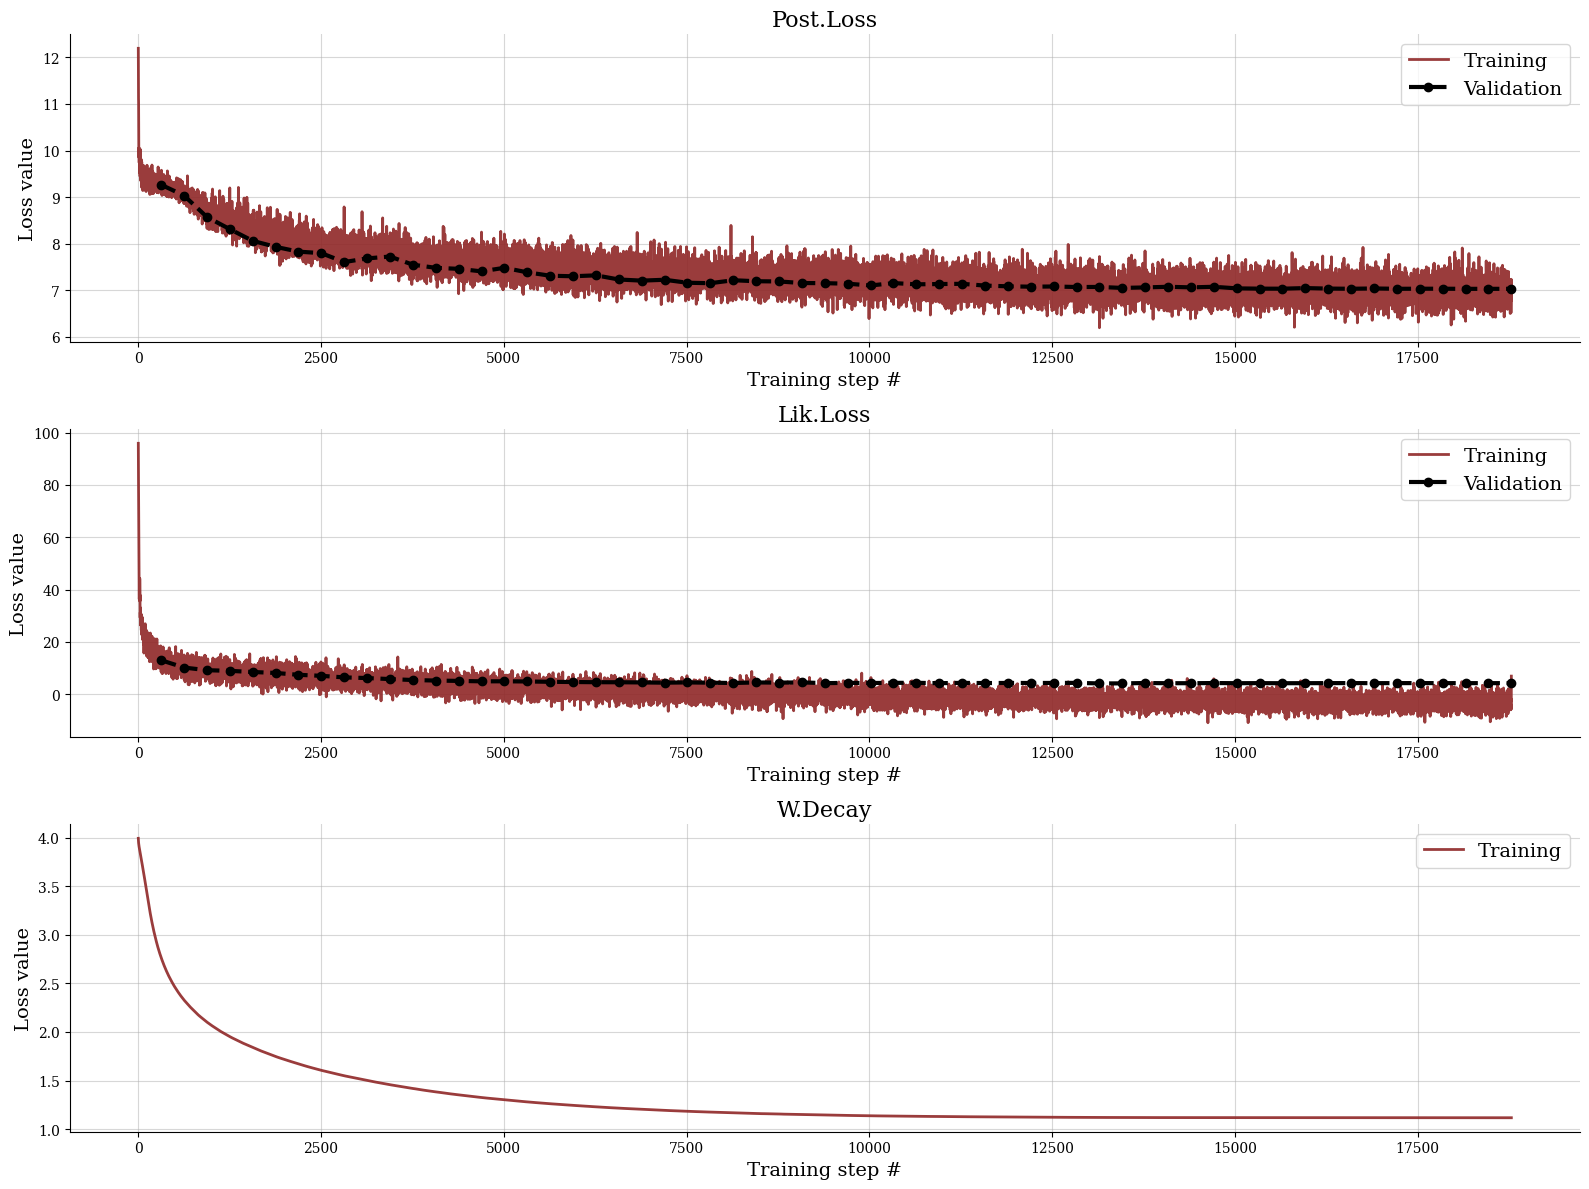

In [21]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])
plt.savefig(f"figures/{benchmark_name}_losses.pdf", dpi=300, bbox_inches="tight")

### Posterior Calibration

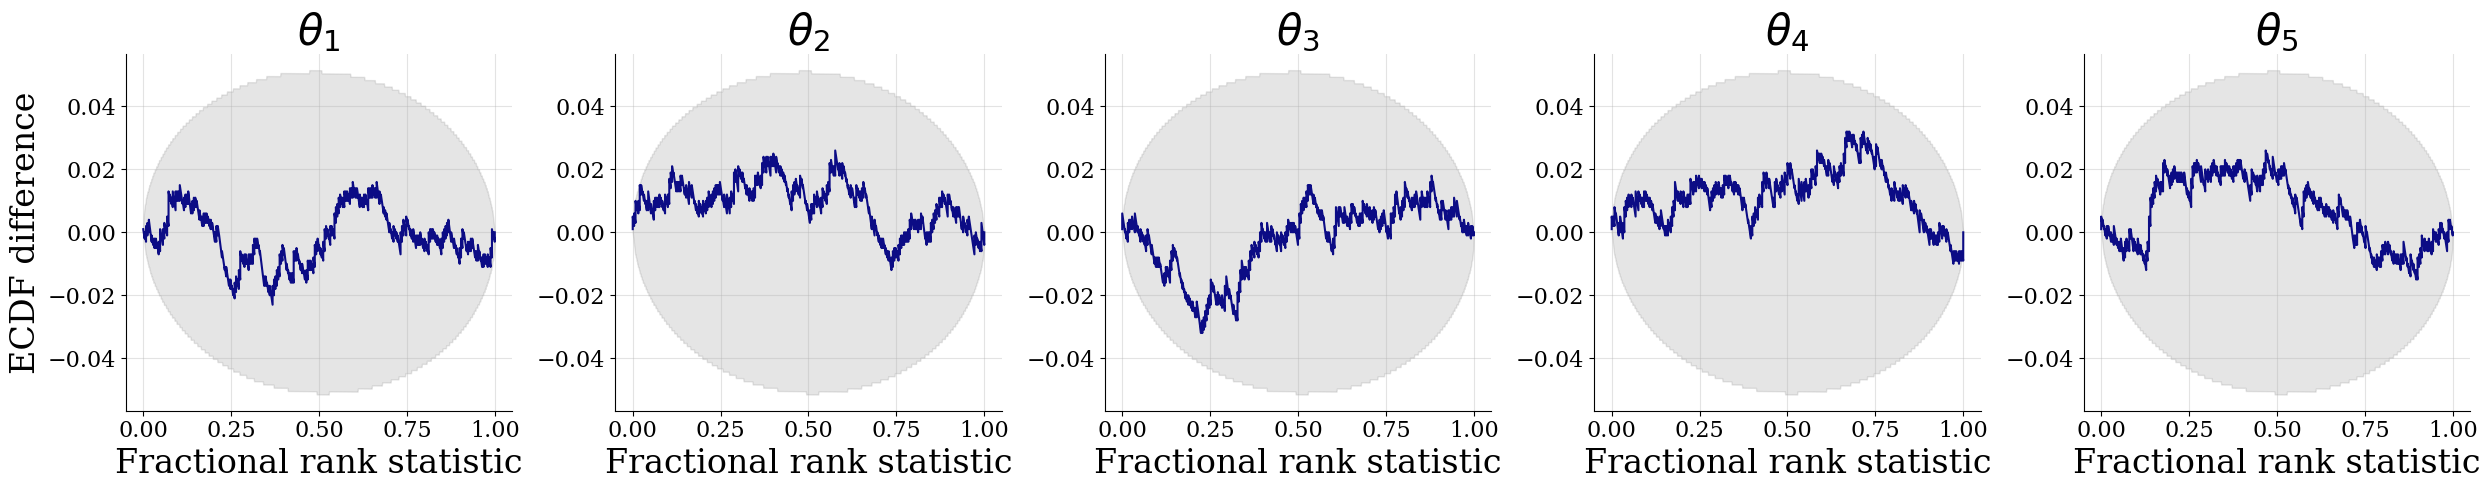

In [22]:
f = plot_sbc_ecdf_appendix(
    post_samples, 
    prior_samples, 
    ecdf_bands_kwargs=dict(confidence=0.95), 
    param_names=benchmark.benchmark_info['parameter_names'],
    label_fontsize=24, 
    legend_fontsize=24, 
    difference=True, 
    rank_ecdf_color='#000080'
)

plt.savefig(f"figures/{benchmark_name}_posterior_calibration_diff_separate.pdf", dpi=300, bbox_inches="tight")

### Joint Calibration

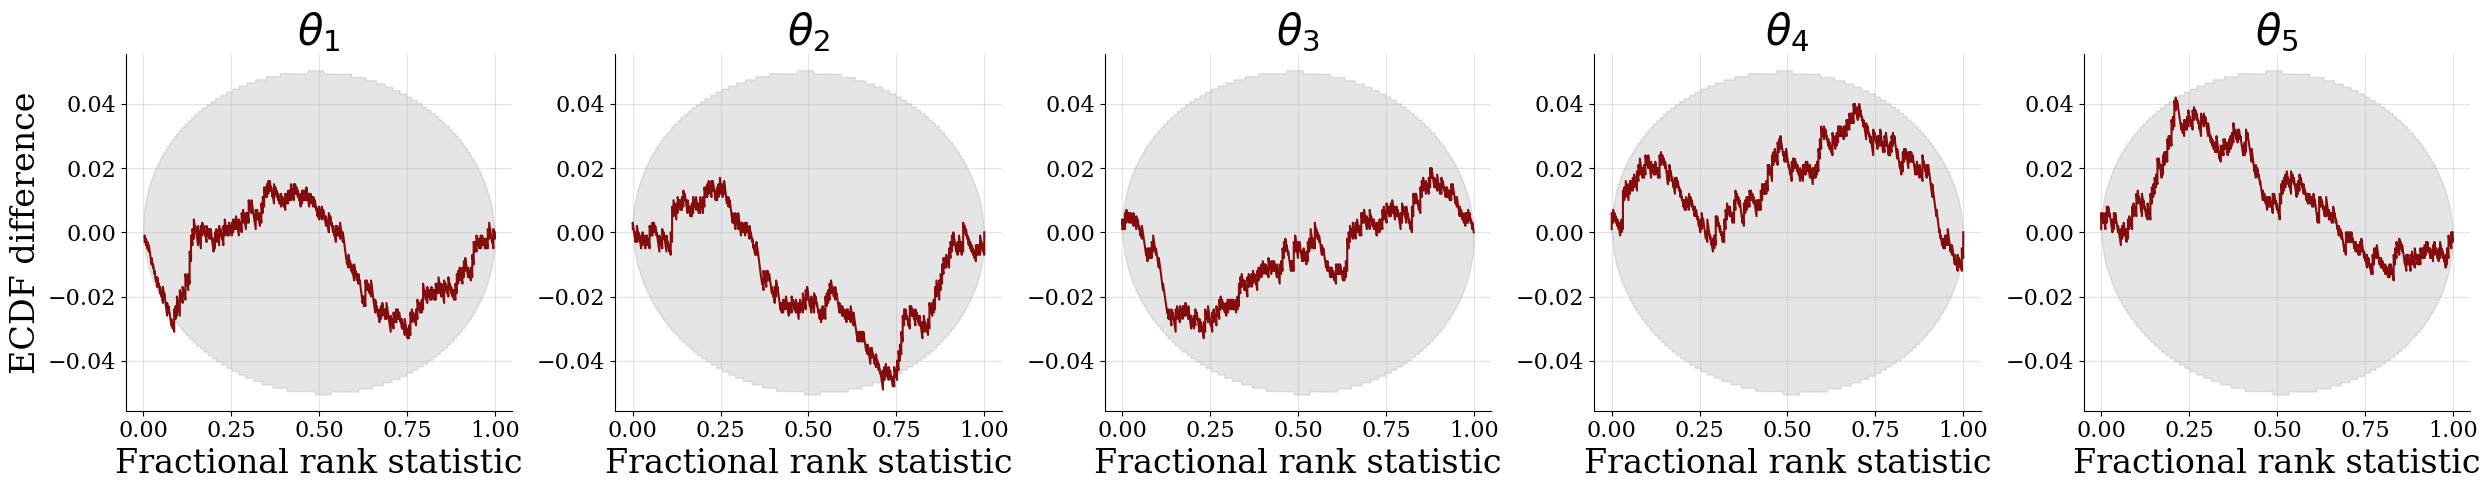

In [23]:
f = plot_sbc_ecdf_appendix(
    post_samples_s, 
    prior_samples, 
    ecdf_bands_kwargs=dict(confidence=0.95), 
    param_names=benchmark.benchmark_info['parameter_names'],
    label_fontsize=24, 
    legend_fontsize=24, 
    difference=True, 
    rank_ecdf_color='#800000'
)

plt.savefig(f"figures/{benchmark_name}_joint_calibration_diff_separate.pdf", dpi=300, bbox_inches="tight")